Based on:

Quantum Computing to find frequencies in an audio file
https://sarangzambare.github.io/jekyll/update/2020/06/13/quantum-frequencies.html


A quantum Fourier transform (QFT) based note detection algorithm
https://arxiv.org/pdf/2204.11775.pdf

In [1]:
import math
import numpy as np
import librosa
from IPython.display import Audio
from librosa import display
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from sympy import *
from matplotlib import pyplot as plt

#musicbar = '900Hz'
#musicbar = '440Hz'
musicbar = 'A-strich'
#musicbar = 'DoubleSine'

file_path = './Music/'+str(musicbar)+'.wav'
file_path2 = './Music/result/'

In [2]:
musicbar = 'A-strich'
file_path = '/Users/XXX/Single_Notes/'+str(musicbar)+'.wav'

### Turn wav audio file into python list of sample amplitudes

In [3]:
# sr = sample rate, original value = 44100
samples, sampling_rate= librosa.load(file_path, sr = None, mono = True, offset= 0.0, duration = None) 
samples = samples.astype('float64')
print("length of the sample:",len(samples)/sampling_rate,"seconds")
print("sampling rate:",sampling_rate,"Hz")
print("Number of samples:",samples.size)

length of the sample: 2.135079365079365 seconds
sampling rate: 44100 Hz
Number of samples: 94157


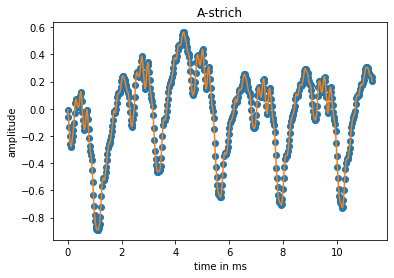

In [4]:
#plot the first 500 smaple points to get a sense of the data

n=500

x = np.arange(n)
x = x/sampling_rate*1000
y = samples[0:n]
plt.title(musicbar) 
plt.xlabel("time in ms") 
plt.ylabel("amplitude") 
plt.plot(x,y,"o") 
plt.plot(x,y)
plt.show()

In [5]:
#reduce the samples array to 2^n_qubits
n_qubits = 10 #number of qubits that will be used to encode samples in QFT
samples.resize((2**n_qubits,),refcheck=False)
print(samples.shape)
print(len(samples), sampling_rate)
print(samples.dtype)

(1024,)
1024 44100
float64


In [6]:
#play the original wav file
Audio(file_path)

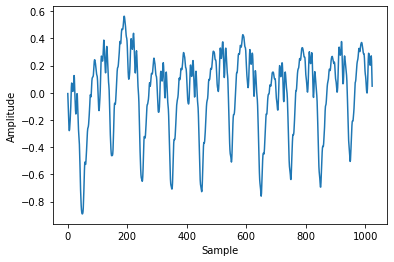

In [7]:
#Turn wav audio file into python list of sample amplitudes
n_qubits = 10 #number of qubits that will be used to encode samples in QFT
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(list(range(len(samples))), samples)

In [8]:
#Encodes a normalized set of amplitudes from the audio samples onto the states of the qubits
def create_encoded_qc(samples):
    amplitudes = len(samples)
    num_qubits = int(math.log2(amplitudes))
    
    q = QuantumRegister(num_qubits) 
    qc = QuantumCircuit(q)
    
    normalized_amplitudes = samples / np.linalg.norm(samples) 
    qc.initialize(normalized_amplitudes, [q[i] for i in range(num_qubits)]) 
    return qc

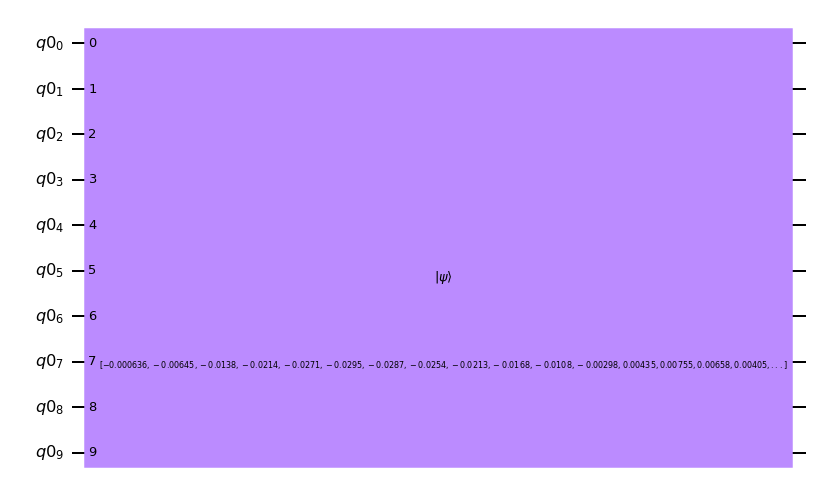

In [9]:
#Create Quantum Circuit
audio_qc = create_encoded_qc(samples)
audio_qc.draw('mpl')

In [10]:
#Apply QFT to quantum circuit, create measurement register, and draw visualization of circuit
audio_qc1 = audio_qc.compose(QFT(num_qubits=n_qubits, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft'))
audio_qc1.measure_all()

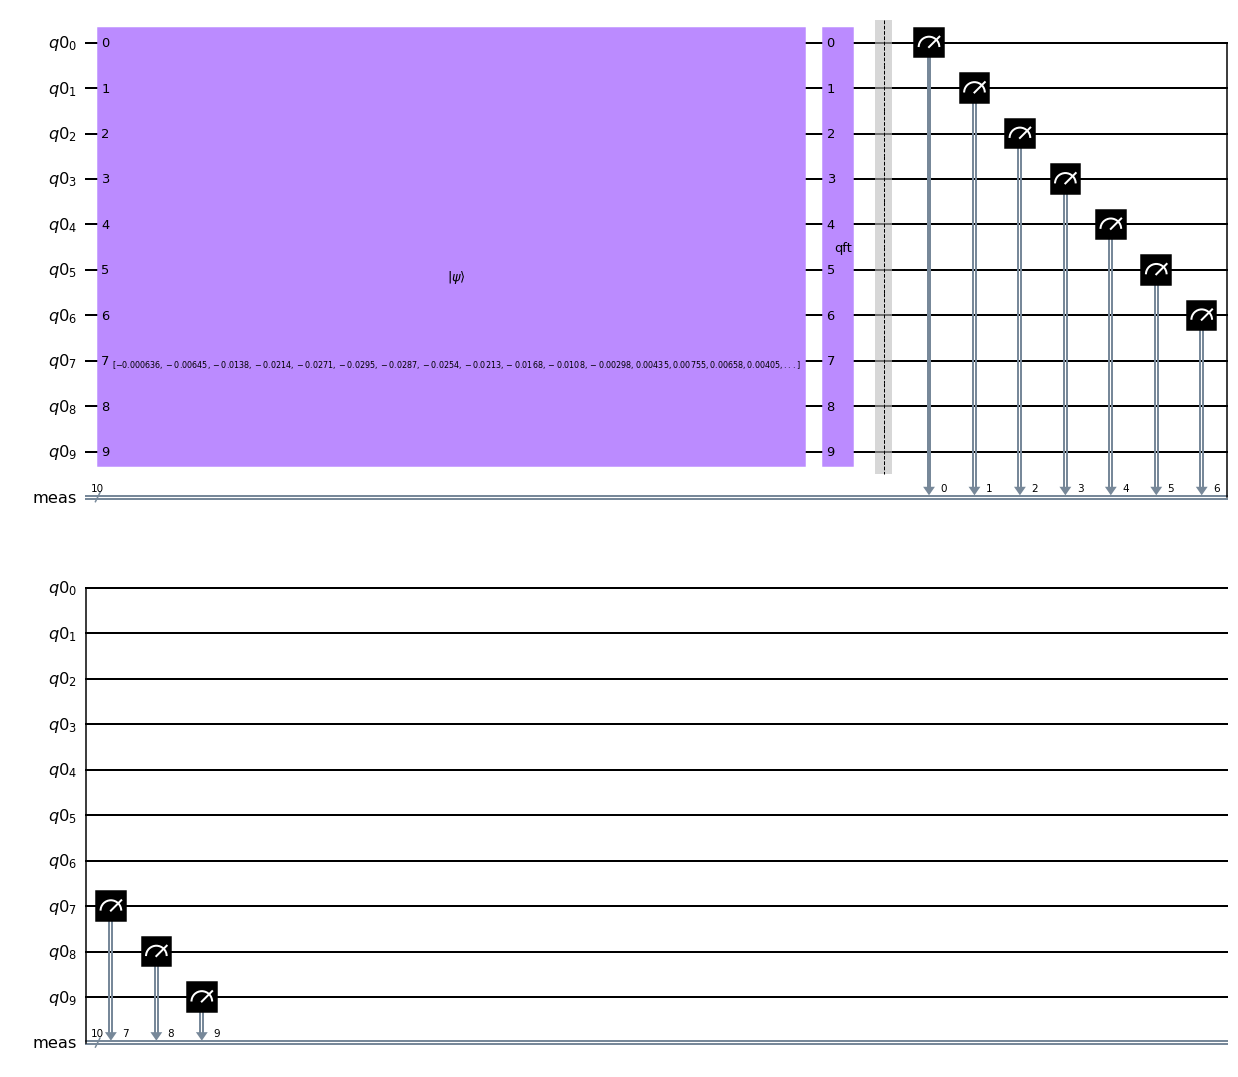

In [11]:
audio_qc1.draw('mpl')

{'0000111101': 1, '1111001110': 1, '1111011110': 1, '0000011010': 1, '0000100011': 1, '0000100111': 1, '1111111000': 1, '1101110011': 1, '0000000100': 3, '1111110011': 1, '1110000101': 2, '1110001111': 2, '1111111001': 1, '0000010000': 2, '1111100001': 3, '0000001100': 5, '0001110001': 1, '0000110010': 1, '1111101001': 2, '0010100101': 1, '0000010011': 10, '0000000101': 21, '1111100000': 1, '0000011011': 1, '0000001011': 21, '0000001001': 9, '0000011111': 8, '1111101110': 5, '1111101101': 4, '1111110000': 1, '1111100010': 5, '0000010010': 5, '0000010110': 7, '0000010111': 3, '1111100100': 1, '0000010001': 2, '1111110100': 5, '0000001111': 3, '1111011000': 1, '1111110101': 30, '0000011110': 3, '1110100100': 2, '0000001101': 3, '0000010101': 35, '1111110111': 15, '0000010100': 49, '1111101100': 73, '0000001010': 218, '1111111100': 5, '1101011100': 1, '1111101010': 4, '0000001110': 4, '1111101011': 44, '1111010111': 12, '0000110011': 8, '0000101101': 1, '0001011100': 5, '1111111011': 26, 

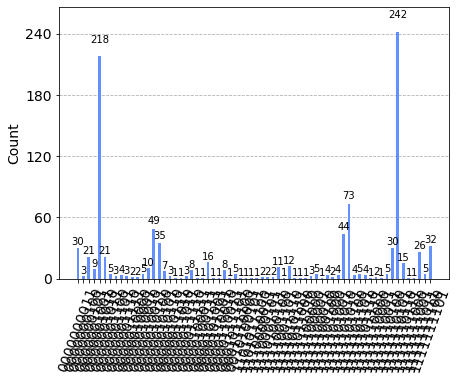

In [12]:
shotno=1024
backend = Aer.get_backend('qasm_simulator')
job = execute(audio_qc1, backend, shots = shotno)
results = job.result()
counts = results.get_counts(audio_qc1)
print(counts)
plot_histogram(counts)

In [13]:
# Counts is a dictionary with the measured state as the key and the count as a value
# Sort the counts by the value (count) rather than the key (measured qbit state)
top_indices = sorted(counts.items(), key=lambda y: y[1], reverse=True)
print(top_indices[:10])

[('1111110110', 242), ('0000001010', 218), ('1111101100', 73), ('0000010100', 49), ('1111101011', 44), ('0000010101', 35), ('1111111101', 32), ('1111110101', 30), ('0000000011', 30), ('1111111011', 26)]


In [14]:
#for i in range(len(top_indices)):
#    print(int(top_indices[i][0], 2)*sampling_rate/samples.size)

In [15]:
def get_fft_from_counts(counts, n_qubits):
    """
    Returns the counts in order of the digital value of the key which is the measured qbit state, i.e. in frequency order
    """
    out = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(counts[id])
        else:
            out.append(0)

    return out

def get_bit_string(n, n_qubits):
    """
    Returns the binary string of an integer with n_qubits characters
    """

    assert n < 2**n_qubits, 'n too big to binarise, increase n_qubits or decrease n'

    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs

    return bs

def plot_samples(samples,factor):

    n=len(samples)
    x = np.arange(n) 
    x=x*factor
    y = samples[0:n]
    plt.title("Frequency Distribution") 
    plt.xlabel("frequnecy") 
    plt.ylabel("counts") 
    plt.plot(x,y,"o") 
    plt.plot(x,y)


Return only frequencies that are below the Nyquist limit of half the sample size
https://en.wikipedia.org/wiki/Nyquist_frequency

For example, audio CDs have a sampling rate of 44100 samples/sec. The Nyquist frequency is therefore 22050 Hz



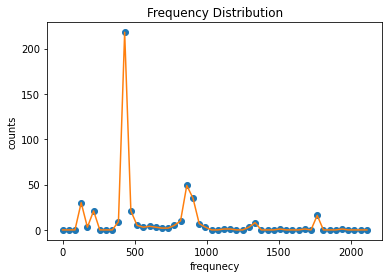

In [16]:
#fft = get_fft_from_counts(counts, n_qubits)[:samples.size//2]
fft = get_fft_from_counts(counts, n_qubits)[:samples.size//2]
plot_samples(fft[0:50],sampling_rate/samples.size)

In [17]:
#Find the frequencies
max_value = max(fft)
max_index = fft.index(max_value)
detected_frequency = []
#find the indexes with counts larger than half the maximum count
for i in range(math.floor(len(fft)/2)):
    if fft[i] > max_value/2:
        detected_frequency.append(i)
#tunr the indices into frequencies by multiplying by sampling_rate/samples.size
for j in range(len(detected_frequency)):
    detected_frequency[j]=detected_frequency[j]*(sampling_rate/samples.size)

print(detected_frequency)

[430.6640625]
